<a href="https://colab.research.google.com/github/Arkaprabha1012/pythonopencv/blob/main/MainCopyFewShotOmniglot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
from __future__ import print_function
from PIL import Image
import numpy as np
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
#%tensorflow_version 1.x

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cd "/content/drive/My Drive/Omniglot"
!pwd

/content


In [ ]:
!unzip "/content/drive/My Drive/Omniglot/omniglot.zip"

Streaming output truncated to the last 5000 lines.
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_01.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_02.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_03.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_04.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_05.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_06.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_07.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_08.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_09.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_10.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_11.png  
  inflating: omniglot/images_evaluation/Mongolian/character16/1374_12.png  
  inflating: omniglot/images_evaluati

In [ ]:
def conv_block(inputs, out_channels, name='conv'):
    with tf.variable_scope(name):
        conv = tf.layers.conv2d(inputs, out_channels, kernel_size=3, padding='SAME')
        conv = tf.contrib.layers.batch_norm(conv, updates_collections=None, decay=0.99, scale=True, center=True)
        conv = tf.nn.relu(conv)
        conv = tf.contrib.layers.max_pool2d(conv, 2)
        return conv

In [ ]:
def encoder(x, h_dim, z_dim, reuse=False):
    with tf.variable_scope('encoder', reuse=reuse):
        net = conv_block(x, h_dim, name='conv_1')
        net = conv_block(net, h_dim, name='conv_2')
        net = conv_block(net, h_dim, name='conv_3')
        net = conv_block(net, z_dim, name='conv_4')
        net = tf.contrib.layers.flatten(net)
        return net


In [ ]:
def euclidean_distance(a, b):
    # a.shape = N x D
    # b.shape = M x D
    N, D = tf.shape(a)[0], tf.shape(a)[1]
    M = tf.shape(b)[0]
    a = tf.tile(tf.expand_dims(a, axis=1), (1, M, 1))
    b = tf.tile(tf.expand_dims(b, axis=0), (N, 1, 1))
    return tf.reduce_mean(tf.square(a - b), axis=2)

In [ ]:
n_epochs = 20
n_episodes = 100
n_way = 60
n_shot = 5
n_query = 5
n_examples = 20
im_width, im_height, channels = 28, 28, 1
h_dim = 64
z_dim = 64

In [ ]:
!pip install -U -q PyDrive

In [ ]:
# Load Train Dataset
root_dir = 'omniglot/images_background/'
train_split_path = os.path.join(root_dir, 'splits', '/content/drive/MyDrive/Omniglot/train.txt')
with open(train_split_path, 'r') as train_split:
    train_classes = [line.rstrip() for line in train_split.readlines()]
n_classes = len(train_classes)
train_dataset = np.zeros([n_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(train_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(root_dir, 'data', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        train_dataset[i, j] = im
print(train_dataset.shape)

(4112, 20, 28, 28)


In [ ]:
#pip install tensorflow==1.4.0

In [ ]:
x = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
q = tf.placeholder(tf.float32, [None, None, im_height, im_width, channels])
x_shape = tf.shape(x)
q_shape = tf.shape(q)
num_classes, num_support = x_shape[0], x_shape[1]
num_queries = q_shape[1]
y = tf.placeholder(tf.int64, [None, None])
y_one_hot = tf.one_hot(y, depth=num_classes)
emb_x = encoder(tf.reshape(x, [num_classes * num_support, im_height, im_width, channels]), h_dim, z_dim)
emb_dim = tf.shape(emb_x)[-1]
emb_x = tf.reduce_mean(tf.reshape(emb_x, [num_classes, num_support, emb_dim]), axis=1)
emb_q = encoder(tf.reshape(q, [num_classes * num_queries, im_height, im_width, channels]), h_dim, z_dim, reuse=True)
dists = euclidean_distance(emb_q, emb_x)
log_p_y = tf.reshape(tf.nn.log_softmax(-dists), [num_classes, num_queries, -1])
ce_loss = -tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_one_hot, log_p_y), axis=-1), [-1]))
acc = tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(log_p_y, axis=-1), y)))

In [ ]:
train_op = tf.train.AdamOptimizer().minimize(ce_loss)

In [ ]:
sess = tf.InteractiveSession()
init_op = tf.global_variables_initializer()
sess.run(init_op)

In [ ]:
for ep in range(n_epochs):
    for epi in range(n_episodes):
        epi_classes = np.random.permutation(n_classes)[:n_way]
        support = np.zeros([n_way, n_shot, im_height, im_width], dtype=np.float32)
        query = np.zeros([n_way, n_query, im_height, im_width], dtype=np.float32)
        for i, epi_cls in enumerate(epi_classes):
            selected = np.random.permutation(n_examples)[:n_shot + n_query]
            support[i] = train_dataset[epi_cls, selected[:n_shot]]
            query[i] = train_dataset[epi_cls, selected[n_shot:]]
        support = np.expand_dims(support, axis=-1)
        query = np.expand_dims(query, axis=-1)
        labels = np.tile(np.arange(n_way)[:, np.newaxis], (1, n_query)).astype(np.uint8)
        _, ls, ac = sess.run([train_op, ce_loss, acc], feed_dict={x: support, q: query, y:labels})
        if (epi+1) % 2 == 0:
            print('[epoch {}/{}, episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(ep+1, n_epochs, epi+1, n_episodes, ls, ac))

[epoch 2/20, episode 50/100] => loss: 4.09434, acc: 0.01667


KeyboardInterrupt: ignored

In [ ]:
# Load Test Dataset
root_dir = 'omniglot/images_background/'
test_split_path = os.path.join(root_dir, 'splits', '/content/drive/MyDrive/Omniglot/test.txt')
with open(test_split_path, 'r') as test_split:
    test_classes = [line.rstrip() for line in test_split.readlines()]
n_test_classes = len(test_classes)
test_dataset = np.zeros([n_test_classes, n_examples, im_height, im_width], dtype=np.float32)
for i, tc in enumerate(test_classes):
    alphabet, character, rotation = tc.split('/')
    rotation = float(rotation[3:])
    im_dir = os.path.join(root_dir, 'data', alphabet, character)
    im_files = sorted(glob.glob(os.path.join(im_dir, '*.png')))
    for j, im_file in enumerate(im_files):
        im = 1. - np.array(Image.open(im_file).rotate(rotation).resize((im_width, im_height)), np.float32, copy=False)
        test_dataset[i, j] = im
print(test_dataset.shape)

In [ ]:
n_test_episodes = 1000
n_test_way = 20
n_test_shot = 5
n_test_query = 15

In [ ]:
avg_acc = 0.
for epi in range(n_test_episodes):
    epi_classes = np.random.permutation(n_test_classes)[:n_test_way]
    support = np.zeros([n_test_way, n_test_shot, im_height, im_width], dtype=np.float32)
    query = np.zeros([n_test_way, n_test_query, im_height, im_width], dtype=np.float32)
    for i, epi_cls in enumerate(epi_classes):
        selected = np.random.permutation(n_examples)[:n_test_shot + n_test_query]
        support[i] = test_dataset[epi_cls, selected[:n_test_shot]]
        query[i] = test_dataset[epi_cls, selected[n_test_shot:]]
    support = np.expand_dims(support, axis=-1)
    query = np.expand_dims(query, axis=-1)
    labels = np.tile(np.arange(n_test_way)[:, np.newaxis], (1, n_test_query)).astype(np.uint8)
    ls, ac = sess.run([ce_loss, acc], feed_dict={x: support, q: query, y:labels})
    avg_acc += ac
    if (epi+1) % 50 == 0:
        print('[test episode {}/{}] => loss: {:.5f}, acc: {:.5f}'.format(epi+1, n_test_episodes, ls, ac))
avg_acc /= n_test_episodes
print('Average Test Accuracy: {:.5f}'.format(avg_acc))


# 2nd Try

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import cv2
from numpy import random as rng
from sklearn.utils import shuffle
import pickle
import time
%tensorflow_version 2.x
from tensorflow.keras.layers import Input, Lambda, Conv2D, MaxPooling2D, BatchNormalization, Dense, Flatten, Activation, Dropout
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K

In [ ]:
!unzip "/content/drive/MyDrive/2 class.zip"

Archive:  /content/drive/MyDrive/2 class.zip
   creating: 2 class/
   creating: 2 class/Pneumonia_not_covid/
  inflating: 2 class/Pneumonia_not_covid/ARDSSevere.png  
  inflating: 2 class/Pneumonia_not_covid/SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day7.jpeg  
  inflating: 2 class/Pneumonia_not_covid/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg  
  inflating: 2 class/Pneumonia_not_covid/SARS-10.1148rg.242035193-g04mr34g05x-Fig5-day9.jpeg  
  inflating: 2 class/Pneumonia_not_covid/pneumocystis-pneumonia-2-PA.png  
  inflating: 2 class/Pneumonia_not_covid/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day2.jpg  
  inflating: 2 class/Pneumonia_not_covid/pneumococcal-pneumonia-day0.jpg  
  inflating: 2 class/Pneumonia_not_covid/pneumococcal-pneumonia-day7.jpg  
  inflating: 2 class/Pneumonia_not_covid/pneumococcal-pneumonia-day35.jpg  
  inflating: 2 class/Pneumonia_not_covid/parapneumonic-effusion-1-PA.png  
  inflating: 2 class/Pneumonia_not_covid/right-upper-lobe-pne

In [ ]:
image_train_dir = 'omniglot/images_background'
image_eval_dir = 'omniglot/images_evaluation'

In [ ]:
def load_data(dir_path):
    X = []
    y = []
    lang_dict = {}
    classNo = 0
    for alphabet in tqdm(sorted(os.listdir(dir_path))):
        lang_dict[alphabet] = [classNo,None]
        alpha_path = os.path.join(dir_path,alphabet)
        for letter in sorted(os.listdir(alpha_path)):
            cat_images= []
            for img in sorted(os.listdir(os.path.join(alpha_path,letter))):
                img_path = os.path.join(alpha_path,letter,img)
                cat_images.append(cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2GRAY))
                y.append(classNo)
            classNo += 1
            X.append(cat_images)
            lang_dict[alphabet][1] = classNo-1
    X = np.array(X)
    y = np.array(y)
#     print(X.shape,y.shape)
    return X, y, lang_dict

In [ ]:
trainImages,trainLabels,lang_dict = load_data(image_train_dir)
valImages,valLabels,lang_dictVal = load_data(image_eval_dir)

100%|██████████| 20/20 [00:01<00:00, 17.98it/s]


In [ ]:
trainImages.shape, trainLabels.shape

((964, 20, 105, 105), (19280,))

In [ ]:
def get_batch(batch_size,dset='train'):
    if dset == 'train':
        X = trainImages
    else:
        X = valImages
    n_classes, n_examples, w, h = X.shape
    cat = rng.choice(n_classes, size=batch_size, replace=False)
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    pairs = [np.zeros((batch_size,w,h,1)) for _ in range(2)]
    for i in range(batch_size):
        ex_no = rng.randint(n_examples)
        pairs[0][i,:,:,:] = X[cat[i],ex_no,:,:].reshape(w,h,1)
        cat2 = 0
        if i >= batch_size // 2:
            cat2 = cat[i]
        else:
            cat2 = (cat[i] + rng.randint(1,n_classes)) % n_classes
        ex_no2 = rng.randint(n_examples)
        pairs[1][i,:,:,:] = X[cat2,ex_no2,:,:].reshape(w,h,1)
    return pairs,targets

In [ ]:
# def generate(batch_size=16,dset='train'):
#     while True:
#         pairs,targets = get_batch(batch_size,dset)
#         yield (pairs,targets)

In [ ]:
def make_one_shot_task(N,dset='val'):
    if dset == 'train':
        X = trainImages
    else:
        X = valImages
    n_classes, n_examples, w, h = X.shape
    cats = rng.choice(n_classes,size=(N,))
    indices = rng.choice(n_examples,size=(N,))
    true_cat = cats[0]
    ex1 = rng.randint(n_examples)
    test_image = np.array([X[true_cat,ex1]]*N).reshape(N,w,h,1)
    support_set = X[cats,indices].reshape(N,w,h,1)
    targets = np.zeros((N,))
    targets[0] = 1
    
    test_image,support_set,targets = shuffle(test_image,support_set,targets)
    
    return [test_image,support_set], targets

In [ ]:
def test_one_shot(model,N,k,dset='val'):
    n_correct = 0
    for _ in range(k):
        inputs, outputs = make_one_shot_task(N,dset)
        preds = model.predict(inputs)
        if np.argmax(outputs) == np.argmax(preds):
            n_correct += 1
    return n_correct / k

In [ ]:
def get_siamese(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    model = Sequential()
    model.add(Conv2D(64,(5,5),input_shape=input_shape,activation='relu',kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128,(5,5),kernel_regularizer='l2'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=2,strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(512,activation='sigmoid',kernel_regularizer='l2'))
    
    left_emb = model(left_input)
    right_emb = model(right_input)
    
    L1_Layer = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))
    L1_Dist = L1_Layer([left_emb,right_emb])
    OP = Dense(1,activation='sigmoid',kernel_regularizer='l2')(L1_Dist)
    
    siamese_net = Model(inputs=[left_input,right_input],outputs=OP)
    
    return siamese_net

In [ ]:
num_iterations = 5000
batch_size = 128

evaluateEvery = 100
# Calculate 250 20-way validation testing
k = 250
N = 20

n_classes, n_examples, w, h = trainImages.shape

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.05,
    decay_steps=4000,
    decay_rate=0.0001)
opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model = get_siamese((w, h, 1))

model.compile(
    loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 105, 105, 1) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 512)          5926528     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512)          0           sequential_1[0][0]         

In [ ]:
lossArr = []
trainAccArr = []
valAccArr = []
currTime = time.time()
for i in range(0,num_iterations+1):
    x,y = get_batch(batch_size)
    loss = model.train_on_batch(x,y)
    if i % evaluateEvery == 0:
        lossArr.append(loss[0])
        trainAcc = round(test_one_shot(model,N,k,'train') * 100,2)
        valAcc = round(test_one_shot(model,N,k,'val') * 100,2)
        trainAccArr.append(trainAcc)
        valAccArr.append(valAcc)
        print('Iteration',i,'('+str(round(time.time() - currTime,1))+'s) - Loss:',loss[0],'Acc:',round(loss[1],2),'',end='')
        print(k,str(N)+'-way train accuracy:', trainAcc,'%, ',end='')
        print(k,str(N)+'-way val accuracy:', valAcc,'%')
        currTime = time.time()

Iteration 0 (32.4s) - Loss: 12.638177871704102 Acc: 0.44 250 20-way train accuracy: 6.8 %, 250 20-way val accuracy: 6.8 %
Iteration 100 (48.9s) - Loss: 8.41303825378418 Acc: 0.79 250 20-way train accuracy: 30.8 %, 250 20-way val accuracy: 26.8 %
Iteration 200 (49.7s) - Loss: 7.297982692718506 Acc: 0.67 250 20-way train accuracy: 40.8 %, 250 20-way val accuracy: 41.2 %
Iteration 300 (49.7s) - Loss: 3.5435492992401123 Acc: 0.75 250 20-way train accuracy: 44.4 %, 250 20-way val accuracy: 33.2 %
Iteration 400 (49.2s) - Loss: 2.282536029815674 Acc: 0.72 250 20-way train accuracy: 38.0 %, 250 20-way val accuracy: 36.8 %
Iteration 500 (49.0s) - Loss: 1.3656904697418213 Acc: 0.8 250 20-way train accuracy: 40.4 %, 250 20-way val accuracy: 40.8 %
Iteration 600 (49.5s) - Loss: 1.132193684577942 Acc: 0.84 250 20-way train accuracy: 58.0 %, 250 20-way val accuracy: 49.6 %
Iteration 700 (49.4s) - Loss: 1.0465855598449707 Acc: 0.83 250 20-way train accuracy: 56.8 %, 250 20-way val accuracy: 52.4 %
It

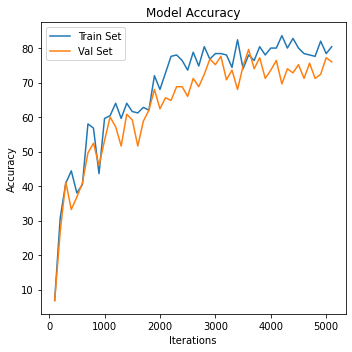

In [ ]:
epochs_range = [i*evaluateEvery for i in range(1, len(trainAccArr) + 1)]

plt.figure(figsize=(5,5))

plt.plot(epochs_range, trainAccArr, label='Train Set')
plt.plot(epochs_range, valAccArr, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
print('Final Validation Accuracy using 250 20-Way One Shot Learning:', round(test_one_shot(model,N,k,'val') * 100,2))

Final Validation Accuracy using 250 20-Way One Shot Learning: 77.2


In [ ]:
model.save('omniglot-siamese.h5')